In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import math

from scipy import stats
from sklearn.preprocessing import StandardScaler

%matplotlib inline


print('numpy version : ',np.__version__)
print('pandas version : ',pd.__version__)
print('seaborn version : ',sns.__version__)

numpy version :  1.26.2
pandas version :  2.0.3
seaborn version :  0.12.2


## Load Dataset

In [2]:
df = pd.read_csv('loan_data_2007_2014.csv')

## Exploratory Data Analysis (EDA)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 75 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   466285 non-null  int64  
 1   id                           466285 non-null  int64  
 2   member_id                    466285 non-null  int64  
 3   loan_amnt                    466285 non-null  int64  
 4   funded_amnt                  466285 non-null  int64  
 5   funded_amnt_inv              466285 non-null  float64
 6   term                         466285 non-null  object 
 7   int_rate                     466285 non-null  float64
 8   installment                  466285 non-null  float64
 9   grade                        466285 non-null  object 
 10  sub_grade                    466285 non-null  object 
 11  emp_title                    438697 non-null  object 
 12  emp_length                   445277 non-null  object 
 13 

* Dataset memiliki total **466285** baris dan 75 fitur
* Terdapat **17 fitur** yang memiliki 0 value

In [4]:
df.sample()

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
229863,229863,1082616,1319296,16400,16400,16375.0,60 months,19.91,433.68,E,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df['id'].nunique()

466285

In [6]:
df['member_id'].nunique()

466285

* Dapat diligat bahwa tidak ada `id` atau `member_id` yang duplikat, artinya setiap baris sudah mewakili satu individu.

## Identify Target Feature

Dalam project credit risk modeling, tujuan utama adalah untuk melakukan prediksi terhadap suatu individu akan kemampuan mereka untuk melakukan pembayaran terhadap pinjaman/kredit yang diberikan. Oleh karena itu, variabel target yang digunakan harus mencerminkan kemampuan individu dalam hal tersebut. 

Dalam dataset ini, variabel `loan_status` adalah variabel yang dapat dijadikan variabel target karena mencerminkan performa masing-masing individu dalam melakukan pembayaran terhadap pinjaman/kredit selama ini.

In [7]:
df['loan_status'].value_counts()

loan_status
Current                                                224226
Fully Paid                                             184739
Charged Off                                             42475
Late (31-120 days)                                       6900
In Grace Period                                          3146
Does not meet the credit policy. Status:Fully Paid       1988
Late (16-30 days)                                        1218
Default                                                   832
Does not meet the credit policy. Status:Charged Off       761
Name: count, dtype: int64

Dapat dilihat bahwa variabel `loan_status` memiliki beberapa nilai:

`Current` artinya pembayaran lancar; `Charged Off` artinya pembayaran macet sehingga dihapusbukukan; `Late` artinya pembayaran telat dilakukan; `In Grace Period` artinya dalam masa tenggang; `Fully Paid` artinya pembayaran lunas; `Default` artinya pembayaran macet

Melakukan grouping antara good_loan_status dan bad_loan_status dari feature `loan_status`. 
<br>
**bad_loan_status:**
* Charged off : dihapusbukukan karena pembayaran macet 
* Default : debitur melewati satu atau lebih tempo pembayaran
* Late (31-120 days) : telat bayar
* Does not meet the credit policy. Status:Charged Off 
<br>

**good_loan_status:**
* Current : belum melewati tenggat waktu
* Fully Paid : pembayaran lunas
* Late (16-30 days) : telat bayar
* In Grace Period : dalam masa tenggang
* Does not meet the credit policy. Status:Fully Paid 

In [8]:
bad_loan_status = [
    'Charged Off' 
    , 'Default' 
    , 'Does not meet the credit policy. Status:Charged Off'
    , 'Late (31-120 days)'
]

df['loan_status_label'] = np.where(df['loan_status'].isin(bad_loan_status), 1, 0)

In [9]:
df['loan_status_label'].value_counts(normalize=True)*100

loan_status_label
0    89.069346
1    10.930654
Name: proportion, dtype: float64

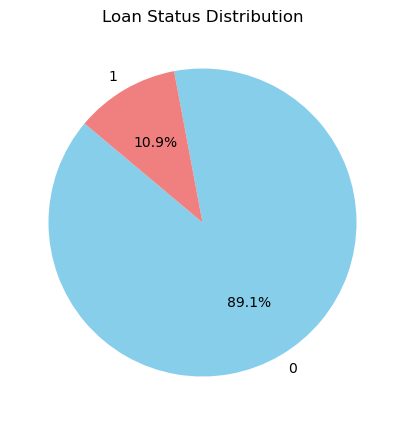

In [10]:
# Count the occurrences of each debt status
loan_status_counts = df['loan_status_label'].value_counts()

# Plotting a pie chart
plt.figure(figsize=(5, 5))
plt.pie(loan_status_counts, labels=loan_status_counts.index, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'lightcoral'])
plt.title('Loan Status Distribution')
plt.tight_layout
plt.show()

Setelah melakukan label flag terhadap bad/good loan, dapat dilihat bahwa jumlah individu yang ditandai sebagai bad loan status jauh lebih sedikit daripada good loan status. Hal ini menyebabkan problem ini menjadi problem imbalanced dataset.

In [11]:
# drop fitur loan_status yang sudah diubah menjadi loan_status_label
df.drop('loan_status', axis= 1, inplace = True)

## 1. Descriptive Statistics

### Check value dari tiap fitur untuk memahami data

In [12]:
for col in df.columns:
    print("{} memiliki {} unique values: {}".format(col, df[col].nunique(), df[col].dtypes))
    if df[col].dtypes == 'int64' or df[col].dtypes == 'float64' or df[col].dtypes == 'object':
        print("{} values: {}".format(col,df[col].unique()))
        print('-' * 100)

Unnamed: 0 memiliki 466285 unique values: int64
Unnamed: 0 values: [     0      1      2 ... 466282 466283 466284]
----------------------------------------------------------------------------------------------------
id memiliki 466285 unique values: int64
id values: [1077501 1077430 1077175 ... 9584776 9604874 9199665]
----------------------------------------------------------------------------------------------------
member_id memiliki 466285 unique values: int64
member_id values: [ 1296599  1314167  1313524 ... 11436914 11457002 11061576]
----------------------------------------------------------------------------------------------------
loan_amnt memiliki 1352 unique values: int64
loan_amnt values: [ 5000  2500  2400 ... 33675 27775 33175]
----------------------------------------------------------------------------------------------------
funded_amnt memiliki 1354 unique values: int64
funded_amnt values: [ 5000  2500  2400 ... 27775 33175 31725]
-------------------------------------

In [13]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,466285.0,2.331420e+05,1.346050e+05,0.00,1.165710e+05,2.331420e+05,3.497130e+05,4.662840e+05
id,466285.0,1.307973e+07,1.089371e+07,54734.00,3.639987e+06,1.010790e+07,2.073121e+07,3.809811e+07
member_id,466285.0,1.459766e+07,1.168237e+07,70473.00,4.379705e+06,1.194108e+07,2.300154e+07,4.086083e+07
loan_amnt,466285.0,1.431728e+04,8.286509e+03,500.00,8.000000e+03,1.200000e+04,2.000000e+04,3.500000e+04
funded_amnt,466285.0,1.429180e+04,8.274371e+03,500.00,8.000000e+03,1.200000e+04,2.000000e+04,3.500000e+04
funded_amnt_inv,466285.0,1.422233e+04,8.297638e+03,0.00,8.000000e+03,1.200000e+04,1.995000e+04,3.500000e+04
int_rate,466285.0,1.382924e+01,4.357587e+00,5.42,1.099000e+01,1.366000e+01,1.649000e+01,2.606000e+01
installment,466285.0,4.320612e+02,2.434855e+02,15.67,2.566900e+02,3.798900e+02,5.665800e+02,1.409990e+03
annual_inc,466281.0,7.327738e+04,5.496357e+04,1896.00,4.500000e+04,6.300000e+04,8.896000e+04,7.500000e+06
dti,466285.0,1.721876e+01,7.851121e+00,0.00,1.136000e+01,1.687000e+01,2.278000e+01,3.999000e+01


* fitur yang tidak memiliki value / **NaN** akan dilakukan drop
* fitur `unnamed = 0`, `id`, `member_id`, dan `policy_code` juga akan dilakukan drop karena terlalu banyak unique value nya

In [14]:
df.describe(exclude = np.number).T

,count,unique,top,freq
term,466285,2,36 months,337953
grade,466285,7,B,136929
sub_grade,466285,35,B3,31686
emp_title,438697,205475,Teacher,5399
emp_length,445277,11,10+ years,150049
home_ownership,466285,6,MORTGAGE,235875
verification_status,466285,3,Verified,168055
issue_d,466285,91,Oct-14,38782
pymnt_plan,466285,2,n,466276
url,466285,466285,https://www.lendingclub.com/browse/loanDetail....,1


* fitur `emp_title`, `url`, `desc`, `title`, `zip_code`, `addr_state` akan di drop karena terlalu banyak unique value nya.
* fitur `application_type` akan di drop karena hanya memiliki 1 unique value.
* fitur `sub_grade` akan dilakukan drop juga karena kurang lebih sama dengan `grade` jadi akan dipilih salah satunya.

In [15]:
# drop fitur yang tidak relevan
fitur_drop = ['Unnamed: 0','id','member_id','policy_code','annual_inc_joint','dti_joint','verification_status_joint',
              'open_acc_6m','open_il_6m','open_il_12m','open_il_24m','max_bal_bc','mths_since_rcnt_il','total_bal_il',
              'il_util','open_rv_12m','open_rv_24m','all_util','inq_fi','total_cu_tl','inq_last_12m','emp_title',
              'url','desc','title','zip_code','addr_state','application_type','sub_grade']

df.drop(fitur_drop, inplace = True, axis = 1)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 46 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   loan_amnt                    466285 non-null  int64  
 1   funded_amnt                  466285 non-null  int64  
 2   funded_amnt_inv              466285 non-null  float64
 3   term                         466285 non-null  object 
 4   int_rate                     466285 non-null  float64
 5   installment                  466285 non-null  float64
 6   grade                        466285 non-null  object 
 7   emp_length                   445277 non-null  object 
 8   home_ownership               466285 non-null  object 
 9   annual_inc                   466281 non-null  float64
 10  verification_status          466285 non-null  object 
 11  issue_d                      466285 non-null  object 
 12  pymnt_plan                   466285 non-null  object 
 13 

**Keterangan Fitur** <br>
* `loan_amnt` : Pembayaran bulan lalu yang diterima
* `funded_amnt`: Jumlah total yang berkomitmen untuk pinjaman itu pada saat itu
* `funded_amnt_inv`: komitment total pembayaran setiap bulannya
* `term`: Jumlah pembayaran atas pinjaman. Nilai dalam beberapa bulan dan dapat berupa 36 atau 60.                        
* `int_rate`: Interest Rate atau peresentase besar bunga yang harus dibayar peminjam.                      
* `installment`: Pembayaran bulanan yang terutang oleh peminjam jika pinjaman berasal.                  
* `grade`: Tingkat risiko atau kualitas pinjaman, biasanya dinilai berdasarkan sejarah kredit peminjam dan faktor-faktor lainnya.
* `emp_length`: Panjang pekerjaan dalam beberapa tahun. Nilai yang mungkin adalah antara 0 dan 10 di mana 0 berarti kurang dari satu tahun dan 10 berarti sepuluh tahun atau lebih.
* `home_ownership`: Status kepemilikan rumah peminjam.
* `annual_inc`: Pendapatan tahunan peminjam.
* `verification_status`: Status verifikasi informasi keuangan peminjam oleh pemberi pinjaman.
* `issue_d`: Tanggal penerbitan pinjaman.
* `loan_status`: Status pinjaman pada saat tertentu.
* `pymnt_plan`: Rencana pembayaran pinjaman.
* `purpose`: Tujuan penggunaan pinjaman.
* `dti`: Rasio hutang terhadap pendapatan peminjam.
* `delinq_2yrs`: Jumlah keterlambatan pembayaran dalam 2 tahun terakhir.
* `earliest_cr_line`: Tanggal pembukaan laporan kredit peminjam.
* `inq_last_6mths`: Jumlah pertanyaan kredit dalam 6 bulan terakhir.
* `mths_since_last_delinq`: Jumlah bulan sejak keterlambatan pembayaran terakhir.
* `mths_since_last_record`: Jumlah bulan sejak catatan kredit terakhir.
* `open_acc`: Jumlah akun kredit terbuka oleh peminjam.
* `pub_rec`: Jumlah catatan publik peminjam.
* `revol_bal`: Total Saldo Revolving Credit.
* `revol_util`: Tingkat pemanfaatan jalur revolving, atau jumlah kredit peminjam menggunakan relatif terhadap semua kredit revolving yang tersedia.
* `total_acc`: Jumlah total akun kredit peminjam.
* `initial_list_status`: Status awal peminjam dalam daftar.
* `out_prncp`: Saldo prinsipal yang belum dibayar pada saat pembayaran terakhir.
* `out_prncp_inv`: Saldo prinsipal yang belum dibayar pada saat pembayaran terakhir, termasuk melibatkan investor.
* `total_pymnt`: Total pembayaran yang telah dibayarkan oleh peminjam.
* `total_pymnt_inv`: Total pembayaran yang telah dibayarkan oleh peminjam, termasuk melibatkan investor.
* `total_rec_prncp`: Total prinsipal yang telah diterima oleh pemberi pinjaman.
* `total_rec_int`: Total bunga yang telah diterima oleh pemberi pinjaman.
* `total_rec_late_fee`: Total biaya keterlambatan yang telah diterima oleh pemberi pinjaman.
* `recoveries`: Total dana yang dipulihkan dari peminjam yang gagal membayar.
* `collection_recovery_fee`: Biaya pemulihan koleksi dari peminjam yang gagal membayar.
* `last_pymnt_d`: Tanggal pembayaran terakhir.
* `last_pymnt_amnt`: Jumlah pembayaran terakhir.
* `next_pymnt_d`: Tanggal pembayaran selanjutnya.
* `last_credit_pull_d`: Tanggal terakhir kali laporan kredit diperbarui.
* `collections_12_mths_ex_med`: Jumlah koleksi dalam 12 bulan terakhir, tanpa kredit medis.
* `mths_since_last_major_derog`: Jumlah bulan sejak kredit utama terakhir yang merugikan.
* `acc_now_delinq`: Jumlah akun yang sedang terlambat membayar.
* `tot_coll_amt`: Jumlah saldo pengumpulan.
* `tot_cur_bal`: Total saldo saat ini dari semua akun.
* `total_rev_hi_lim`: Jumlah tertinggi yang di

## 2. Univariate Analysis

In [17]:
nums = []
catg = []
for i in df.columns:
    if df[i].dtype == 'object':
        catg.append(i)
    else:
        nums.append(i)
print('total = ',len(nums))
print('nums = ',nums)
print('total = ',len(catg))
print('catg = ',catg)

total =  33
nums =  ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'loan_status_label']
total =  13
catg =  ['term', 'grade', 'emp_length', 'home_ownership', 'verification_status', 'issue_d', 'pymnt_plan', 'purpose', 'earliest_cr_line', 'initial_list_status', 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d']


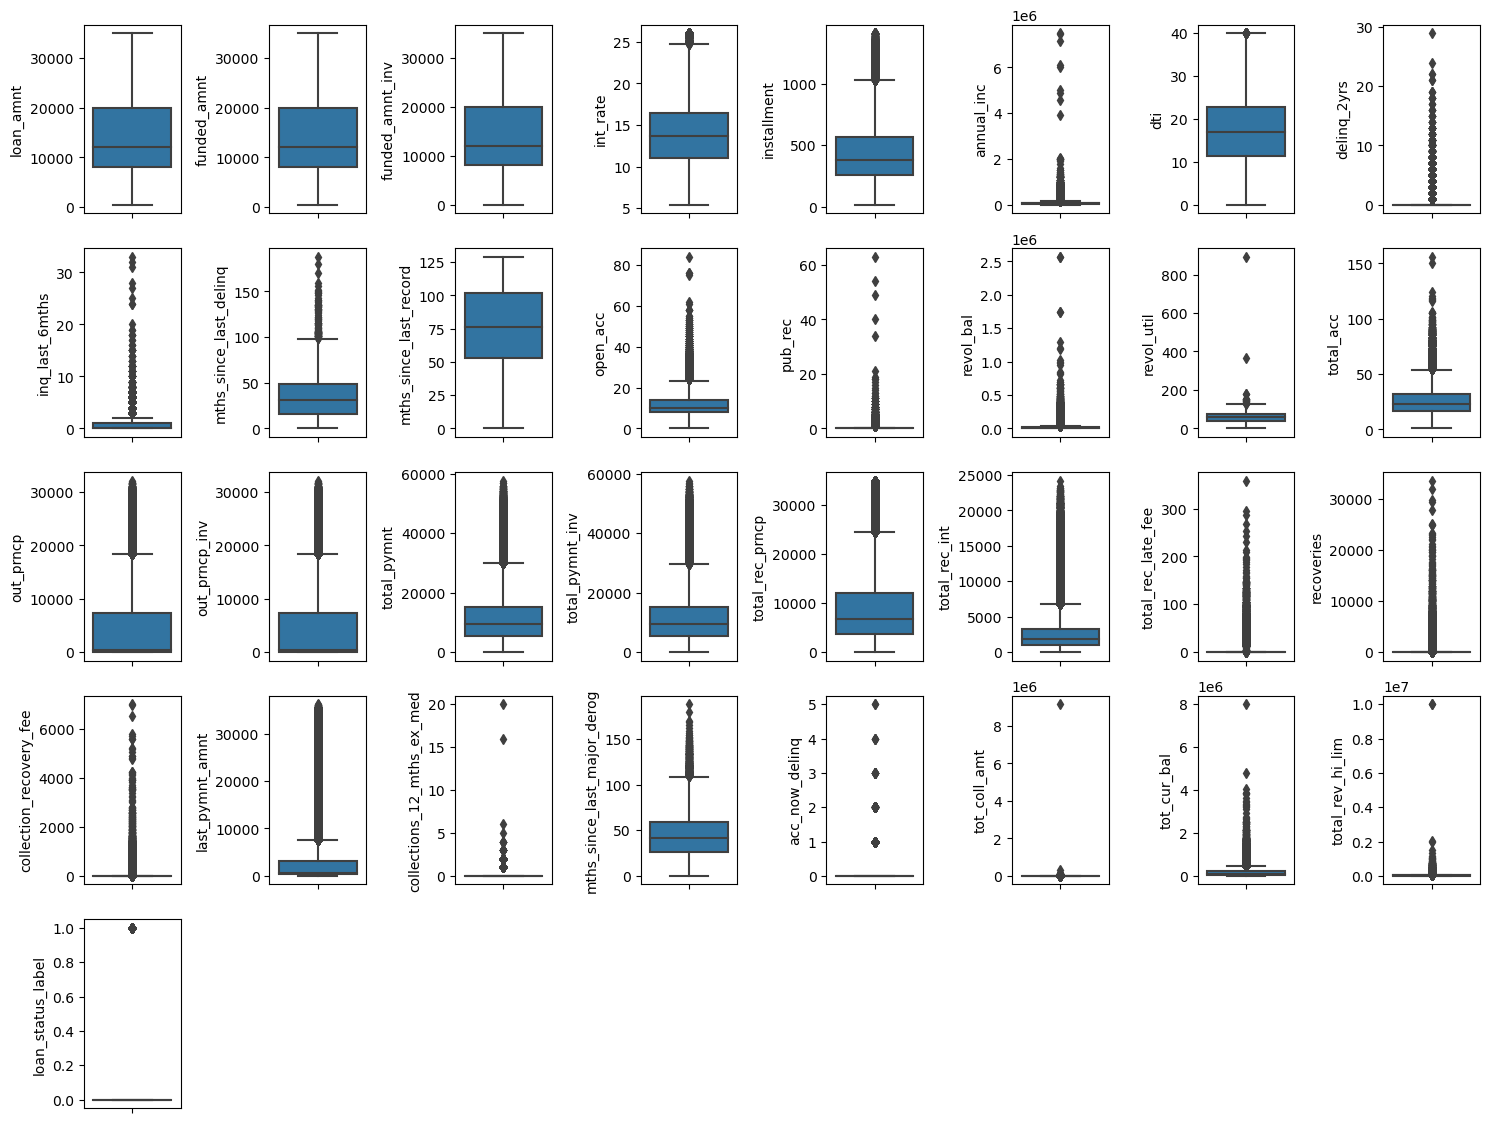

In [18]:
# detect outliers
plt.figure(figsize=(15,18))
for i in range(0,len(nums)):
    plt.subplot(8, 8, i+1)
    sns.boxplot(y = df[nums[i]])
    plt.tight_layout()

* Kebanyakan fitur secara umum memiliki nilai outlier
* Perlu dilakukan handle outlier untuk memudahkan proses selanjutnya

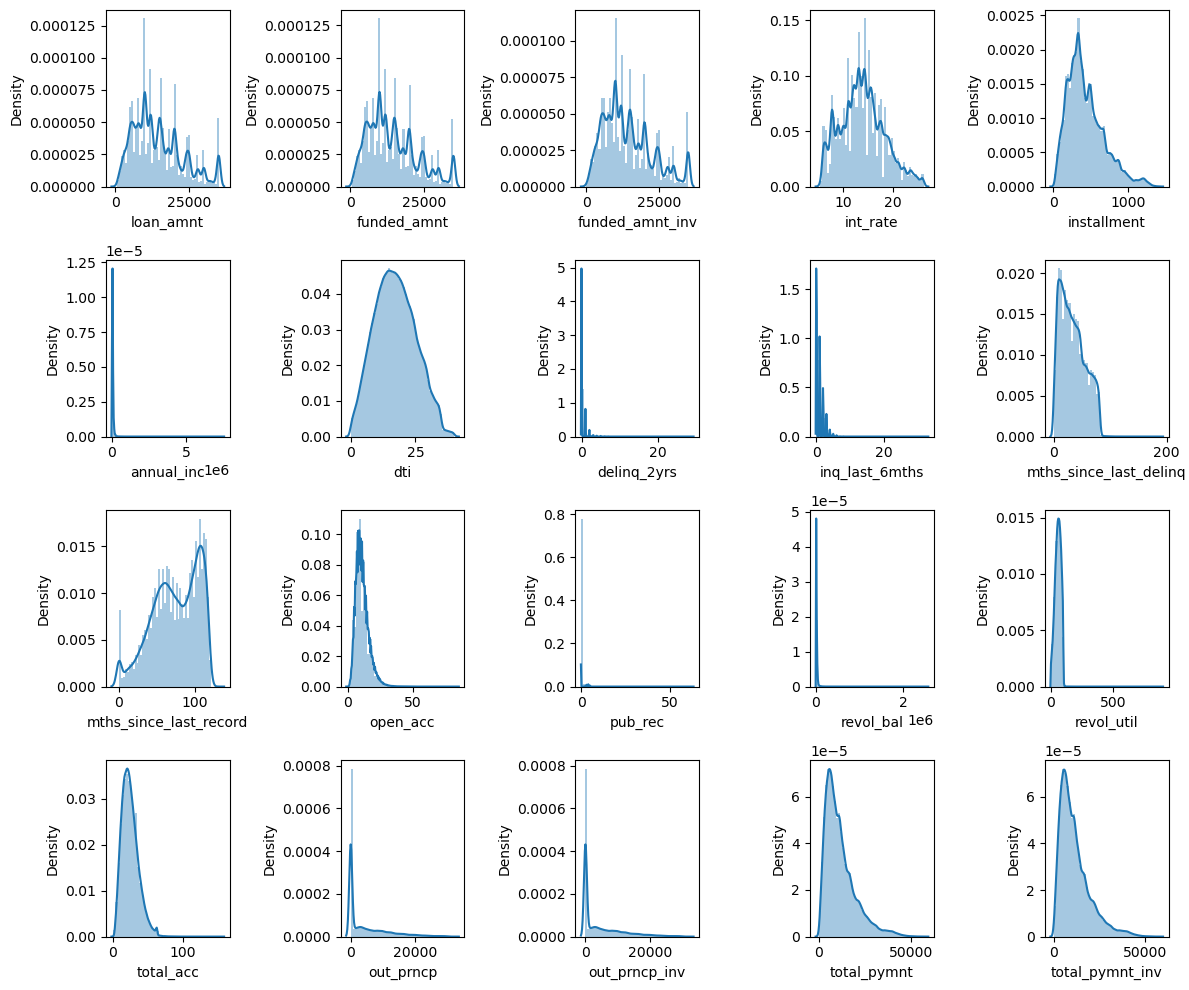

In [19]:
# check numeric distribution
plt.figure(figsize=(12, 10))

# Choose a reasonable number of subplots, e.g., 4 rows and 5 columns
num_rows = 4
num_cols = 5

for i in range(0, min(len(nums), num_rows * num_cols)):
    plt.subplot(num_rows, num_cols, i+1)
    sns.distplot(df[nums[i]])
    plt.tight_layout()

plt.show()

* Fitur secara umum positively skewed, yang mungkin disebabkan oelh outliers, dan missing values

## 3. Business Insight

In [20]:
catg

['term',
 'grade',
 'emp_length',
 'home_ownership',
 'verification_status',
 'issue_d',
 'pymnt_plan',
 'purpose',
 'earliest_cr_line',
 'initial_list_status',
 'last_pymnt_d',
 'next_pymnt_d',
 'last_credit_pull_d']

In [21]:
term_group = df.groupby('term').agg({'loan_amnt':'count'}).reset_index()
term_group.columns = ['term', 'total']
term_group['%'] = round(term_group['total'] * 100 / sum(term_group['total']), 3)
print(term_group)

         term   total       %
0   36 months  337953  72.478
1   60 months  128332  27.522


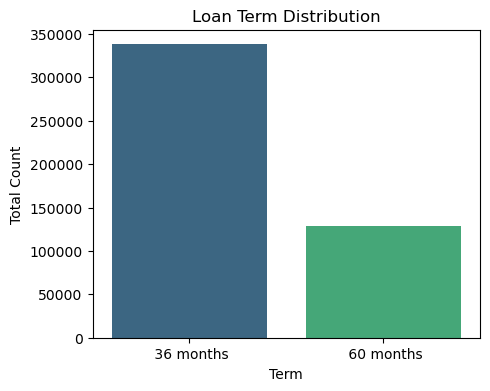

In [22]:
plt.figure(figsize=(5, 4))
sns.barplot(x='term', y='total', data=term_group, palette='viridis')
plt.title('Loan Term Distribution')
plt.ylabel('Total Count')
plt.xlabel('Term')
plt.show()

* Berdasarkan hasil diatas, dapat disimpulkan bahwa sebagian besar pinjaman yang diberikan oleh perusahaan adalah dengan jangka waktu 36 bulan (3 tahun), yang mencakup sekitar 72.48% dari total pinjaman. Sedangkan pinjaman dengan jangka waktu 60 bulan (5 tahun) hanya mencakup sekitar 27.52% dari total pinjaman.
* Dapat diambil insight bahwa mayoritas pelanggan lebih memilih pinjaman dengan jangka waktu yang lebih pendek, yaitu 36 bulan. Ini mungkin karena mereka cenderung lebih memilih untuk melunasi hutang dalam waktu yang lebih singkat.

In [23]:
grade_group = df.groupby('grade').agg({'loan_amnt': 'count'}).reset_index()
grade_group.columns = ['grade', 'total']
grade_group

,grade,total
0,A,74867
1,B,136929
2,C,125293
3,D,76888
4,E,35757
5,F,13229
6,G,3322


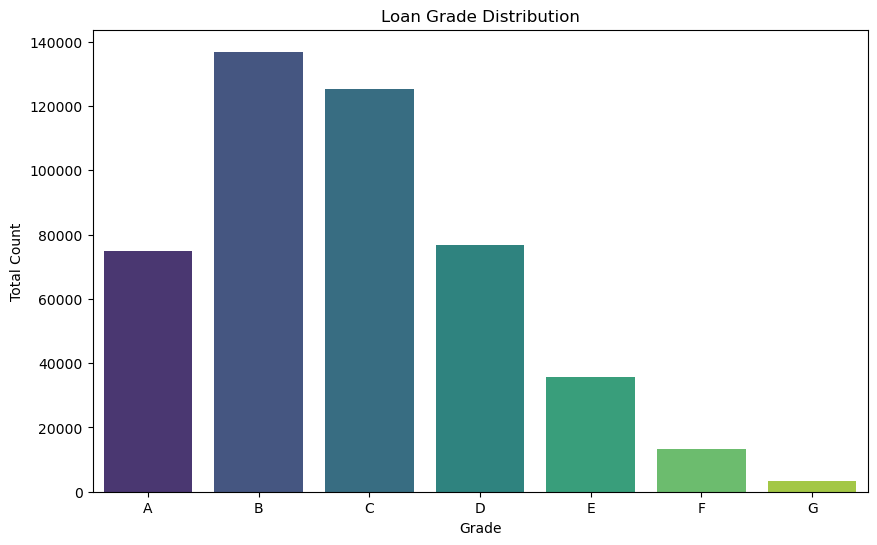

In [24]:
plt.figure(figsize=(10, 6))
sns.barplot(x='grade', y='total', data=grade_group, palette='viridis')
plt.title('Loan Grade Distribution')
plt.ylabel('Total Count')
plt.xlabel('Grade')
plt.show()

* Terlihat bahwa pinjaman dengan grade B memiliki jumlah tertinggi, diikuti oleh grade C dan grade A.
* Pinjaman dengan grade F dan G memiliki jumlah yang lebih rendah dibandingkan dengan grade lainnya.

In [25]:
emp_length_group = df.groupby('emp_length').agg({'loan_amnt': 'count'}).reset_index()
emp_length_group.columns = ['emp_length', 'total']
emp_length_group_sort = emp_length_group.sort_values('total')
emp_length_group_sort

,emp_length,total
9,9 years,17888
8,8 years,22395
6,6 years,26112
7,7 years,26180
4,4 years,28023
0,1 year,29622
5,5 years,30774
10,< 1 year,36265
3,3 years,36596
2,2 years,41373


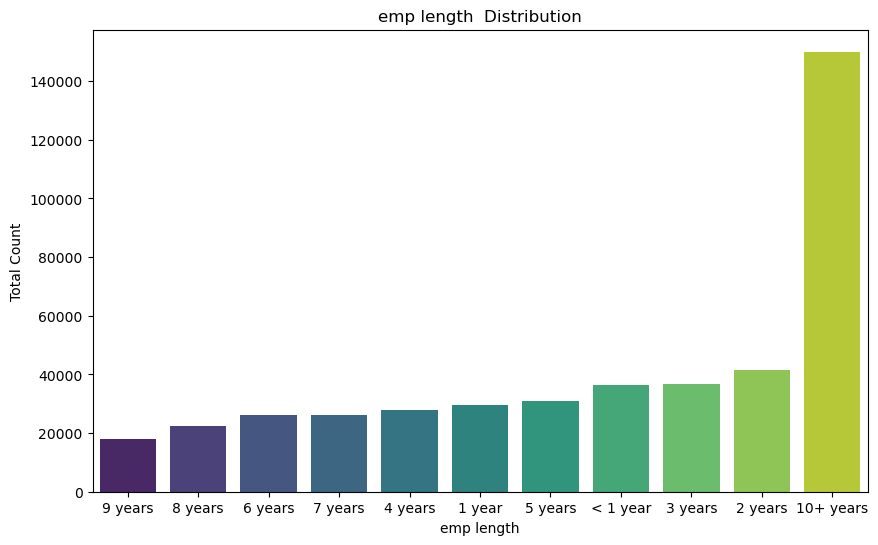

In [26]:
plt.figure(figsize=(10, 6))
sns.barplot(x='emp_length', y='total', data=emp_length_group_sort, palette='viridis')
plt.title('emp length  Distribution')
plt.ylabel('Total Count')
plt.xlabel('emp length')
plt.show()

* emp length dengan  kurang dari 1 tahun (< 1 year) merupakan kelompok terbesar, sementara peminjam dengan emp length lebih dari 10 tahun (10+ years) merupakan kelompok terkecil.

In [27]:
home_own_group = df.groupby('home_ownership').agg({'loan_amnt': 'count'}).reset_index()
home_own_group.columns=['home_ownership','total']
home_own_group = home_own_group.sort_values('total')
home_own_group

,home_ownership,total
0,ANY,1
2,NONE,50
3,OTHER,182
4,OWN,41704
5,RENT,188473
1,MORTGAGE,235875


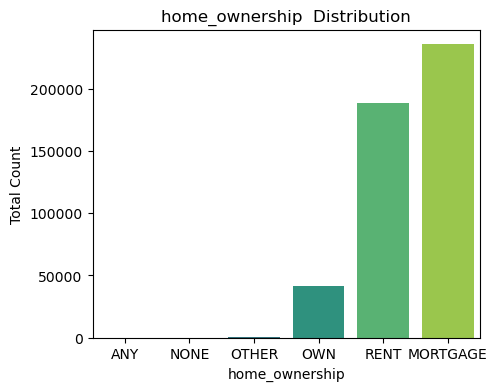

In [28]:
plt.figure(figsize=(5, 4))
sns.barplot(x='home_ownership', y='total', data=home_own_group, palette='viridis')
plt.title('home_ownership  Distribution')
plt.ylabel('Total Count')
plt.xlabel('home_ownership')
plt.show()

* Jumlah peminjam yang tinggal di rumah Mortgage jauh lebih tinggi dibandingkan dengan yang memiliki rumah sendiri (Own) atau yang tinggal di rumah sewa (rent) . Hal ini menunjukkan bahwa mayoritas peminjam cenderung menyewa tempat tinggal atau mencicil, daripada yang memiliki rumah.

In [29]:
purpose_group = df.groupby('purpose').agg({'loan_amnt': 'count'}).reset_index()
purpose_group.columns= ['purpose', 'total']
purpose_group = purpose_group.sort_values('total')
purpose_group

,purpose,total
10,renewable_energy,351
3,educational,422
5,house,2269
13,wedding,2343
12,vacation,2487
8,moving,2994
7,medical,4602
0,car,5397
11,small_business,7013
6,major_purchase,9828


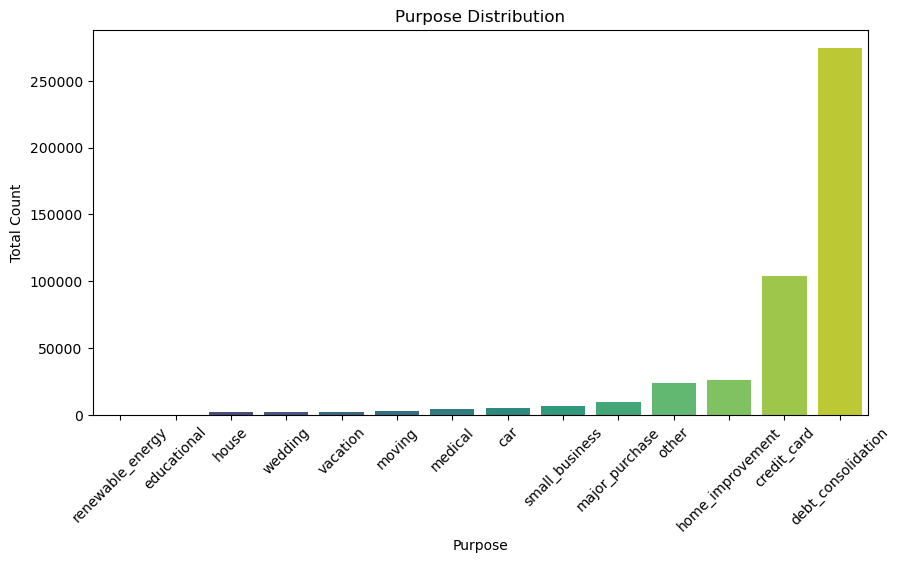

In [30]:
plt.figure(figsize=(10, 5))
sns.barplot(x='purpose', y='total', data=purpose_group, palette='viridis')
plt.title('Purpose Distribution')
plt.ylabel('Total Count')
plt.xlabel('Purpose')
plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees
plt.show()

* Tujuan pinjaman yang paling umum adalah untuk konsolidasi utang ("debt consolidation"), diikuti oleh penggunaan kartu kredit ("credit card"). Hal ini menunjukkan bahwa banyak nasabah menggunakan pinjaman untuk mengelola utang mereka atau untuk membayar tagihan kartu kredit.

## Data Pre-Processing

### 1. Feature Engineering

### emp_length

Mengubah value `emp_length` dari `emp_length` = 4 years menjadi -> `emp_length` = 4

In [31]:
df['emp_length'].unique()

array(['10+ years', '< 1 year', '1 year', '3 years', '8 years', '9 years',
       '4 years', '5 years', '6 years', '2 years', '7 years', nan],
      dtype=object)

In [32]:
# Mengubah nilai '10+ years' menjadi '10' dan nilai '< 1 year' menjadi '0'
df['emp_length'] = df['emp_length'].str.replace('+', '')
df['emp_length'] = df['emp_length'].str.replace('< 1', '0')

# Mengambil hanya angka dari string 'x years'
df['emp_length'] = df['emp_length'].str.extract('(\d+)')

In [33]:
df['emp_length'].unique()

array(['10', '0', '1', '3', '8', '9', '4', '5', '6', '2', '7', nan],
      dtype=object)

In [34]:
df['emp_length'] = df['emp_length'].astype(float)

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 46 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   loan_amnt                    466285 non-null  int64  
 1   funded_amnt                  466285 non-null  int64  
 2   funded_amnt_inv              466285 non-null  float64
 3   term                         466285 non-null  object 
 4   int_rate                     466285 non-null  float64
 5   installment                  466285 non-null  float64
 6   grade                        466285 non-null  object 
 7   emp_length                   445277 non-null  float64
 8   home_ownership               466285 non-null  object 
 9   annual_inc                   466281 non-null  float64
 10  verification_status          466285 non-null  object 
 11  issue_d                      466285 non-null  object 
 12  pymnt_plan                   466285 non-null  object 
 13 

## term

Mengubah value `term` = 36 months -> `term` = 36

In [36]:
df['term'].value_counts()

term
 36 months    337953
 60 months    128332
Name: count, dtype: int64

In [37]:
df['term'] = df['term'].str.replace(' months', '')
df['term'] = df['term'].astype(float)

In [38]:
df['term'].value_counts()

term
36.0    337953
60.0    128332
Name: count, dtype: int64

### earliest_cr_line

Memodifikasi `earliest_cr_line` dari format bulan-tahun menjadi perhitungan berapa lama waktu berlalu sejak waktu tersebut. Untuk melakukan hal ini, umumnya digunakan reference date = hari ini. Namun, karena dataset ini merupakan dataset tahun 2007-2014, maka akan lebih relevan jika menggunakan reference date di sekitar tahun yang tidak jauh dari periode dataset. Dalam kasus ini akan dipilih menggunakan tanggal 2016-12-01 sebagai reference date.

In [39]:
df['earliest_cr_line'].value_counts()

earliest_cr_line
Oct-00    3674
Aug-00    3597
Aug-01    3455
Oct-99    3406
Oct-01    3329
          ... 
Jul-55       1
Feb-57       1
Oct-54       1
May-53       1
Nov-56       1
Name: count, Length: 664, dtype: int64

In [40]:
df['earliest_cr_line_date'] = pd.to_datetime(df['earliest_cr_line'], format='%b-%y')
df['earliest_cr_line_date'].head(3)

0   1985-01-01
1   1999-04-01
2   2001-11-01
Name: earliest_cr_line_date, dtype: datetime64[ns]

In [41]:
df['mths_since_earliest_cr_line'] = round(pd.to_numeric((pd.to_datetime('2016-12-01') - df['earliest_cr_line_date']) / np.timedelta64(1, 'M')))
df['mths_since_earliest_cr_line'].head(3)

0    376.0
1    208.0
2    178.0
Name: mths_since_earliest_cr_line, dtype: float64

In [42]:
df['mths_since_earliest_cr_line'].describe()

count    466256.000000
mean        223.364641
std          92.270429
min        -613.000000
25%         168.000000
50%         209.000000
75%         268.000000
max         565.000000
Name: mths_since_earliest_cr_line, dtype: float64

In [43]:
df[df['mths_since_earliest_cr_line']<0][['earliest_cr_line', 'earliest_cr_line_date', 'mths_since_earliest_cr_line']].head(3)

,earliest_cr_line,earliest_cr_line_date,mths_since_earliest_cr_line
1580,Sep-62,2062-09-01,-539.0
1770,Sep-68,2068-09-01,-610.0
2799,Sep-64,2064-09-01,-563.0


Terdapat nilai min(-) dikarenakan Python salah menginterpretasikan tahun 62 menjadi tahun 2062, padahal seharusnya merupakan tahun 1962.

Karena nilai yang negatif artinya adalah data yang sudah tua di tahun 19-an, maka kan diubah nilai negatif tersebut menjadi nilai maksimum.

In [44]:
df.loc[df['mths_since_earliest_cr_line']<0, 'mths_since_earliest_cr_line'] = df['mths_since_earliest_cr_line'].max()

In [45]:
df.drop(['earliest_cr_line', 'earliest_cr_line_date'], axis=1, inplace=True)

### issue_d

Akan dilakukan preprocessing yang sama seperti feature `earliest_cr_line`

In [46]:
df['issue_d_date'] = pd.to_datetime(df['issue_d'], format='%b-%y')
df['mths_since_issue_d'] = round(pd.to_numeric((pd.to_datetime('2017-12-01') - df['issue_d_date']) / np.timedelta64(1, 'M')))

In [47]:
df['mths_since_issue_d'].describe()

count    466285.000000
mean         50.204806
std          14.190212
min          35.000000
25%          40.000000
50%          46.000000
75%          56.000000
max         124.000000
Name: mths_since_issue_d, dtype: float64

In [48]:
df.drop(['issue_d', 'issue_d_date'], axis=1, inplace=True)

### last_pymnt_d

Akan dilakukan preprocessing yang sama seperti feature `earliest_cr_line`

In [49]:
df['last_pymnt_d_date'] = pd.to_datetime(df['last_pymnt_d'], format='%b-%y')
df['mths_since_last_pymnt_d'] = round(pd.to_numeric((pd.to_datetime('2017-12-01') - df['last_pymnt_d_date']) / np.timedelta64(1, 'M')))

In [50]:
df['mths_since_last_pymnt_d'].describe()

count    465909.000000
mean         30.916097
std          12.406823
min          23.000000
25%          23.000000
50%          24.000000
75%          34.000000
max         118.000000
Name: mths_since_last_pymnt_d, dtype: float64

In [51]:
df.drop(['last_pymnt_d', 'last_pymnt_d_date'], axis=1, inplace=True)

### next_pymnt_d

Akan dilakukan preprocessing yang sama seperti feature `earliest_cr_line`

In [52]:
df['next_pymnt_d_date'] = pd.to_datetime(df['next_pymnt_d'], format='%b-%y')
df['mths_since_next_pymnt_d'] = round(pd.to_numeric((pd.to_datetime('2017-12-01') - df['next_pymnt_d_date']) / np.timedelta64(1, 'M')))

In [53]:
df['mths_since_next_pymnt_d'].describe()

count    239071.000000
mean         22.722279
std           5.928592
min          21.000000
25%          22.000000
50%          22.000000
75%          22.000000
max         118.000000
Name: mths_since_next_pymnt_d, dtype: float64

In [54]:
df.drop(['next_pymnt_d', 'next_pymnt_d_date'], axis=1, inplace=True)

### last_credit_pull_d

Akan dilakukan preprocessing yang sama seperti feature `earliest_cr_line`

In [55]:
df['last_credit_pull_d_date'] = pd.to_datetime(df['last_credit_pull_d'], format='%b-%y')
df['mths_since_last_credit_pull_d'] = round(pd.to_numeric((pd.to_datetime('2017-12-01') - df['last_credit_pull_d_date']) / np.timedelta64(1, 'M')))

In [56]:
df['mths_since_last_credit_pull_d'].describe()

count    466243.000000
mean         26.856223
std           9.303991
min          23.000000
25%          23.000000
50%          23.000000
75%          25.000000
max         125.000000
Name: mths_since_last_credit_pull_d, dtype: float64

In [57]:
df.drop(['last_credit_pull_d', 'last_credit_pull_d_date'], axis=1, inplace=True)

### 2. Check Feature Correlation

In [58]:
numeric_columns = df.select_dtypes(exclude=['object'])

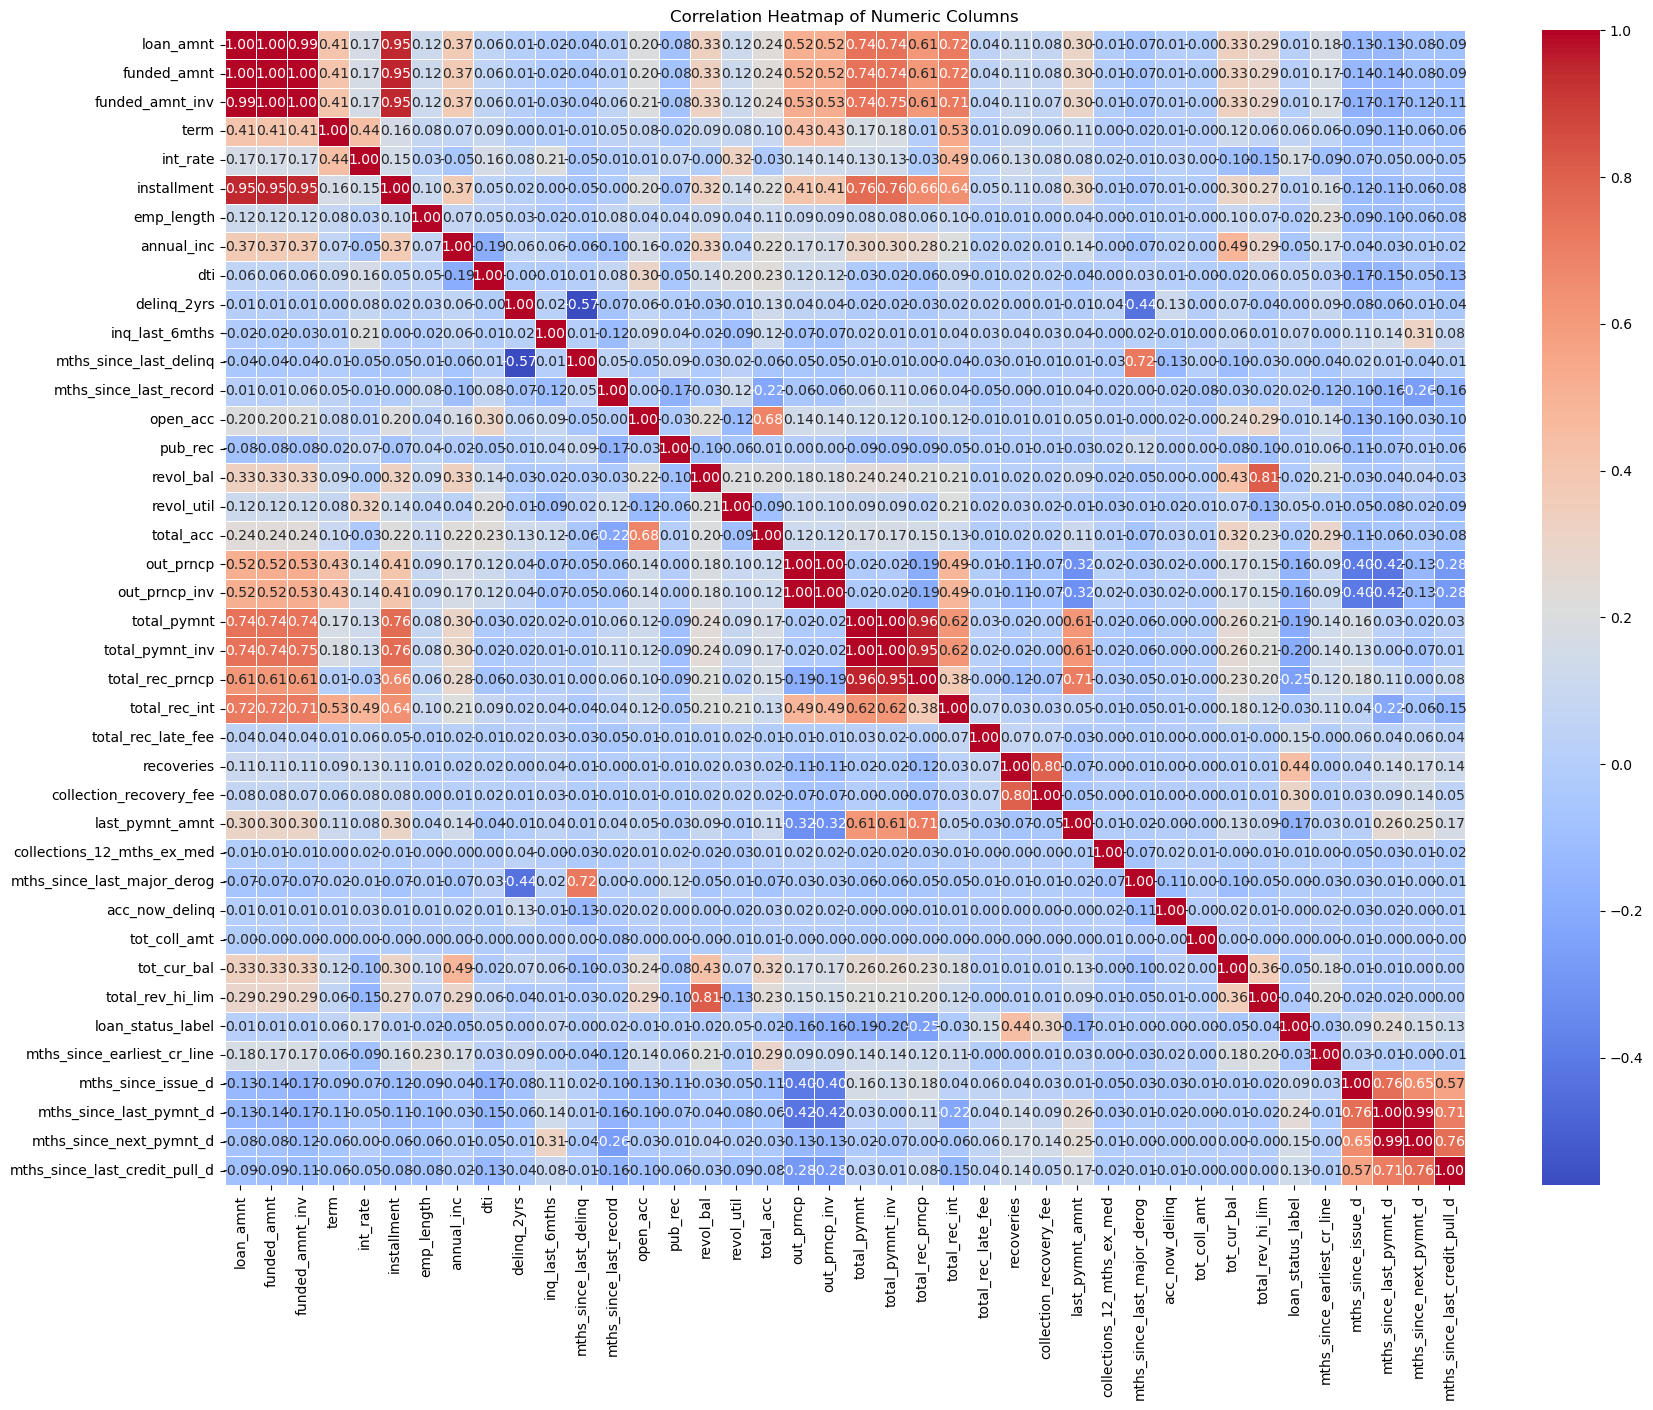

In [59]:
corr_matrix = numeric_columns.corr()

plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Numeric Columns')
plt.show()

Jika ada pasangan fitur-fitur yang memiliki korelasi tinggi maka akan diambil salah satu saja. Nilai korelasi yang dijadikan patokan sebagai korelasi tinggi tidak pasti, umumnya digunakan angka 0.7.

In [60]:
# Create a mask to select only the upper triangle of the correlation matrix
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Iterate over the columns of the correlation matrix
dropped_features = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        # Check if the correlation value is greater than 0.7 and if the feature has not been dropped already
        if (corr_matrix.iloc[i, j] >= 0.7) and (corr_matrix.columns[j] not in dropped_features):
            dropped_features.add(corr_matrix.columns[i])


dropped_features

{'collection_recovery_fee',
 'funded_amnt',
 'funded_amnt_inv',
 'installment',
 'last_pymnt_amnt',
 'mths_since_last_credit_pull_d',
 'mths_since_last_major_derog',
 'mths_since_last_pymnt_d',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_int',
 'total_rev_hi_lim'}

In [61]:
# Drop the highly correlated features from the dataframe
df.drop(dropped_features, axis=1, inplace=True)

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 33 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   loan_amnt                    466285 non-null  int64  
 1   term                         466285 non-null  float64
 2   int_rate                     466285 non-null  float64
 3   grade                        466285 non-null  object 
 4   emp_length                   445277 non-null  float64
 5   home_ownership               466285 non-null  object 
 6   annual_inc                   466281 non-null  float64
 7   verification_status          466285 non-null  object 
 8   pymnt_plan                   466285 non-null  object 
 9   purpose                      466285 non-null  object 
 10  dti                          466285 non-null  float64
 11  delinq_2yrs                  466256 non-null  float64
 12  inq_last_6mths               466256 non-null  float64
 13 

### 3. Check Categorical and Numerical Features

In [63]:
df.select_dtypes(include='object').nunique()

grade                   7
home_ownership          6
verification_status     3
pymnt_plan              2
purpose                14
initial_list_status     2
dtype: int64

In [64]:
df.select_dtypes(exclude='object').nunique()

loan_amnt                        1352
term                                2
int_rate                          506
emp_length                         11
annual_inc                      31901
dti                              3997
delinq_2yrs                        24
inq_last_6mths                     28
mths_since_last_delinq            145
mths_since_last_record            123
open_acc                           62
pub_rec                            26
revol_bal                       58142
revol_util                       1269
total_acc                         112
out_prncp                      135665
total_rec_prncp                172713
total_rec_late_fee               5808
recoveries                      22773
collections_12_mths_ex_med          9
acc_now_delinq                      6
tot_coll_amt                     6321
tot_cur_bal                    220690
loan_status_label                   2
mths_since_earliest_cr_line       506
mths_since_issue_d                 90
mths_since_n

In [65]:
for col in df.select_dtypes(include='object').columns.tolist():
    print(df[col].value_counts(normalize=True)*100)
    print('\n')

grade
B    29.365946
C    26.870476
D    16.489486
A    16.056060
E     7.668486
F     2.837106
G     0.712440
Name: proportion, dtype: float64


home_ownership
MORTGAGE    50.586015
RENT        40.420129
OWN          8.943886
OTHER        0.039032
NONE         0.010723
ANY          0.000214
Name: proportion, dtype: float64


verification_status
Verified           36.041262
Source Verified    32.167666
Not Verified       31.791072
Name: proportion, dtype: float64


pymnt_plan
n    99.99807
y     0.00193
Name: proportion, dtype: float64


purpose
debt_consolidation    58.804165
credit_card           22.337626
home_improvement       5.691155
other                  5.080584
major_purchase         2.107724
small_business         1.504016
car                    1.157447
medical                0.986950
moving                 0.642097
vacation               0.533365
wedding                0.502482
house                  0.486612
educational            0.090503
renewable_energy       0.075276


Fitur `pymnt_plan `sangat didominasi oleh salah satu nilai saja, maka di drop.

In [66]:
df.drop('pymnt_plan', axis = 1, inplace= True)

### 4. Check Missing Value

In [67]:
check_missing = df.isnull().sum() * 100 / df.shape[0]
check_missing[check_missing > 0].sort_values(ascending=False)

mths_since_last_record         86.566585
mths_since_last_delinq         53.690554
mths_since_next_pymnt_d        48.728567
tot_coll_amt                   15.071469
tot_cur_bal                    15.071469
emp_length                      4.505399
revol_util                      0.072917
collections_12_mths_ex_med      0.031097
delinq_2yrs                     0.006219
inq_last_6mths                  0.006219
open_acc                        0.006219
pub_rec                         0.006219
total_acc                       0.006219
acc_now_delinq                  0.006219
mths_since_earliest_cr_line     0.006219
annual_inc                      0.000858
dtype: float64

Missing values yang memiliki persentase diatas 75% akan di drop.

In [68]:
df.drop('mths_since_last_record', axis=1, inplace= True)

In [69]:
# feature imputation
# feature `annual_inc` akan diisi dengan mean sedangkan fitur lainnya akan diisi dengan nilai 0
df['annual_inc'].fillna(df['annual_inc'].mean(), inplace=True)
df['mths_since_earliest_cr_line'].fillna(0, inplace=True)
df['acc_now_delinq'].fillna(0, inplace=True)
df['total_acc'].fillna(0, inplace=True)
df['pub_rec'].fillna(0, inplace=True)
df['open_acc'].fillna(0, inplace=True)
df['inq_last_6mths'].fillna(0, inplace=True)
df['delinq_2yrs'].fillna(0, inplace=True)
df['collections_12_mths_ex_med'].fillna(0, inplace=True)
df['revol_util'].fillna(0, inplace=True)
df['emp_length'].fillna(0, inplace=True)
df['tot_cur_bal'].fillna(0, inplace=True)
df['tot_coll_amt'].fillna(0, inplace=True)
df['mths_since_last_delinq'].fillna(0, inplace=True)
df['mths_since_next_pymnt_d'].fillna(0, inplace=True)

In [70]:
df.isnull().sum()

loan_amnt                      0
term                           0
int_rate                       0
grade                          0
emp_length                     0
home_ownership                 0
annual_inc                     0
verification_status            0
purpose                        0
dti                            0
delinq_2yrs                    0
inq_last_6mths                 0
mths_since_last_delinq         0
open_acc                       0
pub_rec                        0
revol_bal                      0
revol_util                     0
total_acc                      0
initial_list_status            0
out_prncp                      0
total_rec_prncp                0
total_rec_late_fee             0
recoveries                     0
collections_12_mths_ex_med     0
acc_now_delinq                 0
tot_coll_amt                   0
tot_cur_bal                    0
loan_status_label              0
mths_since_earliest_cr_line    0
mths_since_issue_d             0
mths_since

### 5. Check Duplciate Value

In [71]:
df.duplicated().sum()

0

## Feature Transormation

### 1. Feature Encoding


In [72]:
categorical_cols = [col for col in df.select_dtypes(include='object').columns.tolist()]

In [73]:
onehot = pd.get_dummies(df[categorical_cols], drop_first=True)

In [74]:
onehot.head()

,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,...,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,initial_list_status_w
0,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
3,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
4,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False


In [75]:
df = pd.concat([df, onehot], axis=1)

In [76]:
df.drop(['grade', 'home_ownership', 'verification_status', 'purpose', 'initial_list_status'], axis=1, inplace=True)

In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 53 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   loan_amnt                            466285 non-null  int64  
 1   term                                 466285 non-null  float64
 2   int_rate                             466285 non-null  float64
 3   emp_length                           466285 non-null  float64
 4   annual_inc                           466285 non-null  float64
 5   dti                                  466285 non-null  float64
 6   delinq_2yrs                          466285 non-null  float64
 7   inq_last_6mths                       466285 non-null  float64
 8   mths_since_last_delinq               466285 non-null  float64
 9   open_acc                             466285 non-null  float64
 10  pub_rec                              466285 non-null  float64
 11  revol_bal    

### 2. Standarization

In [78]:
numerical_cols = [col for col in df.columns.tolist() if col not in categorical_cols + ['loan_status_label']]

In [79]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
std = pd.DataFrame(ss.fit_transform(df[numerical_cols]), columns=numerical_cols)

In [80]:
std.sample(3)

,loan_amnt,term,int_rate,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,...,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,initial_list_status_w
260944,-1.220935,-0.616225,-0.548294,1.138605,-0.423508,1.084081,-0.357012,-0.737182,0.496794,-0.237839,...,-0.069928,-0.146735,-0.099839,-0.080389,-0.231355,-0.027447,-0.123571,-0.073227,-0.071065,-0.734077
107296,1.047815,-0.616225,-0.731882,0.339900,0.486190,-0.198540,-0.357012,0.178920,-0.700148,0.363587,...,-0.069928,-0.146735,-0.099839,-0.080389,-0.231355,-0.027447,-0.123571,-0.073227,-0.071065,-0.734077
133889,0.685781,1.622784,-0.842035,-0.458805,-0.314344,-0.217645,-0.357012,2.011124,-0.700148,1.566439,...,-0.069928,-0.146735,-0.099839,-0.080389,-0.231355,-0.027447,-0.123571,-0.073227,-0.071065,-0.734077


In [81]:
df = pd.concat([df.drop(columns=numerical_cols), std], axis=1)

In [82]:
df.head()

,loan_status_label,loan_amnt,term,int_rate,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,...,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,initial_list_status_w
0,0,-1.124392,-0.616225,-0.729587,1.138605,-0.896551,1.328632,-0.357012,0.178920,-0.700148,...,-0.069928,-0.146735,-0.099839,-0.080389,-0.231355,-0.027447,-0.123571,-0.073227,-0.071065,-0.734077
1,1,-1.426088,1.622784,0.330634,-1.523744,-0.787387,-2.065791,-0.357012,3.843328,-0.700148,...,-0.069928,-0.146735,-0.099839,-0.080389,-0.231355,-0.027447,-0.123571,-0.073227,-0.071065,-0.734077
2,0,-1.438156,-0.616225,0.488979,1.138605,-1.110294,-1.082491,-0.357012,1.095022,-0.700148,...,-0.069928,-0.146735,-0.099839,-0.080389,-0.231355,-0.027447,8.092507,-0.073227,-0.071065,-0.734077
3,0,-0.521001,-0.616225,-0.077850,1.138605,-0.438063,0.354248,-0.357012,0.178920,0.851444,...,-0.069928,-0.146735,-0.099839,-0.080389,4.322358,-0.027447,-0.123571,-0.073227,-0.071065,-0.734077
4,0,-1.365749,1.622784,-0.261438,-1.257509,0.122311,0.091865,-0.357012,-0.737182,0.984438,...,-0.069928,-0.146735,-0.099839,-0.080389,4.322358,-0.027447,-0.123571,-0.073227,-0.071065,-0.734077


## Split Data Train & Test

In [83]:
from sklearn.model_selection import train_test_split

In [84]:
X = df.drop('loan_status_label', axis=1)
y = df['loan_status_label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [85]:
X_train.head()

,loan_amnt,term,int_rate,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,...,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,initial_list_status_w
427211,1.168494,-0.616225,-1.131186,-0.725040,0.067729,0.597526,-0.357012,0.178920,-0.700148,1.766914,...,-0.069928,-0.146735,-0.099839,-0.080389,-0.231355,-0.027447,-0.123571,-0.073227,-0.071065,-0.734077
206088,-0.521001,-0.616225,0.114918,0.073665,0.704518,-1.239157,0.897154,1.095022,0.097814,0.764538,...,-0.069928,-0.146735,-0.099839,-0.080389,-0.231355,-0.027447,-0.123571,-0.073227,-0.071065,-0.734077
136020,0.737069,-0.616225,-1.131186,1.138605,0.195087,-0.304257,-0.357012,0.178920,1.339087,-0.438314,...,-0.069928,-0.146735,-0.099839,-0.080389,-0.231355,-0.027447,-0.123571,-0.073227,-0.071065,-0.734077
412305,0.347882,-0.616225,0.633554,0.339900,-0.550866,-0.450733,0.897154,2.011124,-0.434161,-0.438314,...,-0.069928,-0.146735,-0.099839,-0.080389,-0.231355,-0.027447,-0.123571,-0.073227,-0.071065,-0.734077
36159,-0.714086,-0.616225,-0.227015,-0.192570,0.377027,0.677769,-0.357012,0.178920,-0.700148,0.564063,...,-0.069928,-0.146735,-0.099839,-0.080389,-0.231355,-0.027447,-0.123571,-0.073227,-0.071065,-0.734077


In [86]:
X_test.head()

,loan_amnt,term,int_rate,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,...,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,initial_list_status_w
362514,2.194258,1.622784,0.266378,-1.523744,-0.150598,-1.006069,-0.357012,-0.737182,-0.700148,-0.839264,...,-0.069928,-0.146735,-0.099839,-0.080389,-0.231355,-0.027447,-0.123571,-0.073227,-0.071065,-0.734077
288564,-0.400323,1.622784,1.643288,1.138605,-0.241568,0.887930,0.897154,-0.737182,-0.567154,1.365964,...,-0.069928,-0.146735,-0.099839,-0.080389,-0.231355,-0.027447,-0.123571,-0.073227,-0.071065,1.362255
213591,1.892563,-0.616225,0.188353,-1.257509,1.850738,-0.494039,-0.357012,-0.737182,1.117431,-0.438314,...,-0.069928,-0.146735,-0.099839,-0.080389,-0.231355,-0.027447,-0.123571,-0.073227,-0.071065,-0.734077
263083,0.009983,1.622784,0.151635,-0.991274,-0.132404,0.060022,-0.357012,-0.737182,-0.700148,0.163112,...,-0.069928,-0.146735,-0.099839,-0.080389,-0.231355,-0.027447,-0.123571,-0.073227,-0.071065,1.362255
165001,0.082390,-0.616225,-1.131186,1.138605,0.213281,-1.135986,-0.357012,-0.737182,1.028769,-0.839264,...,-0.069928,-0.146735,-0.099839,-0.080389,-0.231355,-0.027447,-0.123571,-0.073227,-0.071065,-0.734077


## Modelling & Evaluation

### 1. Random Forest

In [87]:
from sklearn.ensemble import RandomForestClassifier

In [88]:
rf_model = RandomForestClassifier(max_depth=4)
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=4)

### 2.Metric Evaluation

Dalam mengukur performa model menggunakan metrik yang umum dipakai dalam dunia credit risk yaitu AUC  (Area Under the ROC Curve) dan KS (Kolmogorov-Smirnov).

In [89]:
y_pred_proba = rf_model.predict_proba(X_test)[:][:,1]

df_actual_predicted = pd.concat([pd.DataFrame(np.array(y_test), columns=['y_actual']), pd.DataFrame(y_pred_proba, columns=['y_pred_proba'])], axis=1)
df_actual_predicted.index = y_test.index

### AUC

In [90]:
from sklearn.metrics import roc_curve, roc_auc_score

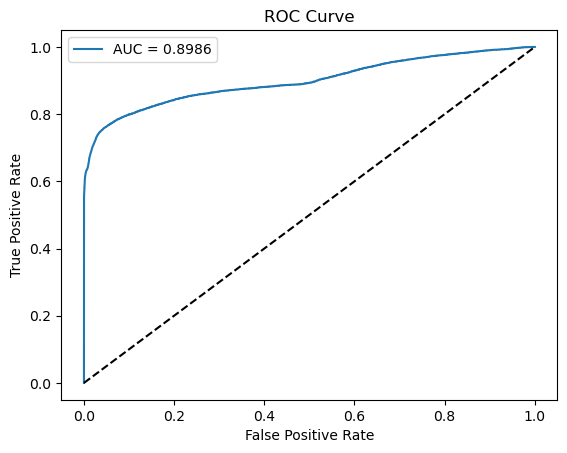

In [91]:
fpr, tpr, tr = roc_curve(df_actual_predicted['y_actual'], df_actual_predicted['y_pred_proba'])
auc = roc_auc_score(df_actual_predicted['y_actual'], df_actual_predicted['y_pred_proba'])

plt.plot(fpr, tpr, label='AUC = %0.4f' %auc)
plt.plot(fpr, fpr, linestyle = '--', color='k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

### KS

In [92]:
df_actual_predicted = df_actual_predicted.sort_values('y_pred_proba')
df_actual_predicted = df_actual_predicted.reset_index()

df_actual_predicted['Cumulative N Population'] = df_actual_predicted.index + 1
df_actual_predicted['Cumulative N Bad'] = df_actual_predicted['y_actual'].cumsum()
df_actual_predicted['Cumulative N Good'] = df_actual_predicted['Cumulative N Population'] - df_actual_predicted['Cumulative N Bad']
df_actual_predicted['Cumulative Perc Population'] = df_actual_predicted['Cumulative N Population'] / df_actual_predicted.shape[0]
df_actual_predicted['Cumulative Perc Bad'] = df_actual_predicted['Cumulative N Bad'] / df_actual_predicted['y_actual'].sum()
df_actual_predicted['Cumulative Perc Good'] = df_actual_predicted['Cumulative N Good'] / (df_actual_predicted.shape[0] - df_actual_predicted['y_actual'].sum())

In [93]:
df_actual_predicted.head()

,index,y_actual,y_pred_proba,Cumulative N Population,Cumulative N Bad,Cumulative N Good,Cumulative Perc Population,Cumulative Perc Bad,Cumulative Perc Good
0,322307,0,0.032922,1,0,1,0.000011,0.0,0.000012
1,245818,0,0.033074,2,0,2,0.000021,0.0,0.000024
2,299920,0,0.033120,3,0,3,0.000032,0.0,0.000036
3,362747,0,0.033175,4,0,4,0.000043,0.0,0.000048
4,378542,0,0.033201,5,0,5,0.000054,0.0,0.000060


Text(0.5, 1.0, 'Kolmogorov-Smirnov:  0.7142')

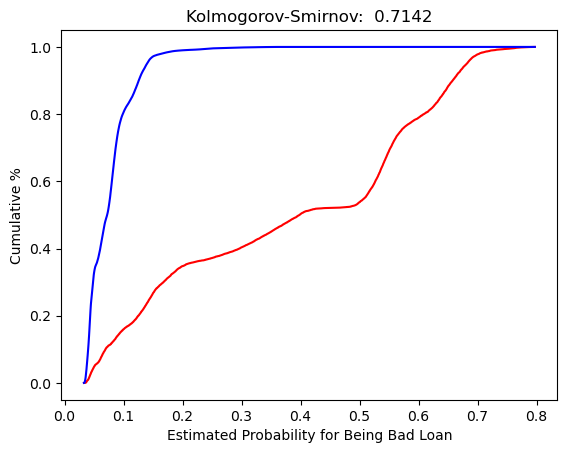

In [94]:
KS = max(df_actual_predicted['Cumulative Perc Good'] - df_actual_predicted['Cumulative Perc Bad'])

plt.plot(df_actual_predicted['y_pred_proba'], df_actual_predicted['Cumulative Perc Bad'], color='r')
plt.plot(df_actual_predicted['y_pred_proba'], df_actual_predicted['Cumulative Perc Good'], color='b')
plt.xlabel('Estimated Probability for Being Bad Loan')
plt.ylabel('Cumulative %')
plt.title('Kolmogorov-Smirnov:  %0.4f' %KS)

## Conclusion

Berdasarkan hasil evaluasi metrik, model yang telah dikembangkan menunjukkan performa cukup baik untuk pemodelan credit risk. Dengan nilai AUC mencapai 0.857 dan KS sebesar 0.56 dalam dunia pemodelan credit risk, nilai AUC di atas 0.7 dan KS di atas 0.3 sering dianggap sebagai tanda performa yang baik, mengindikasikan kemampuan model untuk mengklasifikasikan pemohon kredit dengan akurasi yang tinggi. Model tersebut menunjukkan kemampuan yang kuat dalam membedakan antara pemohon kredit yang berpotensi good loan dan bad loan status

### 3. Feature Importance

In [95]:
feature_importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

                                Feature    Importance
17                           recoveries  4.532297e-01
15                      total_rec_prncp  1.970437e-01
24              mths_since_next_pymnt_d  1.001853e-01
14                            out_prncp  8.891276e-02
16                   total_rec_late_fee  5.613143e-02
2                              int_rate  3.527183e-02
0                             loan_amnt  1.690800e-02
23                   mths_since_issue_d  1.054533e-02
1                                  term  1.006706e-02
27                              grade_D  4.408108e-03
28                              grade_E  4.224984e-03
21                          tot_cur_bal  3.660860e-03
29                              grade_F  3.347329e-03
4                            annual_inc  2.907318e-03
7                        inq_last_6mths  2.198868e-03
25                              grade_B  2.014692e-03
5                                   dti  1.817039e-03
12                          

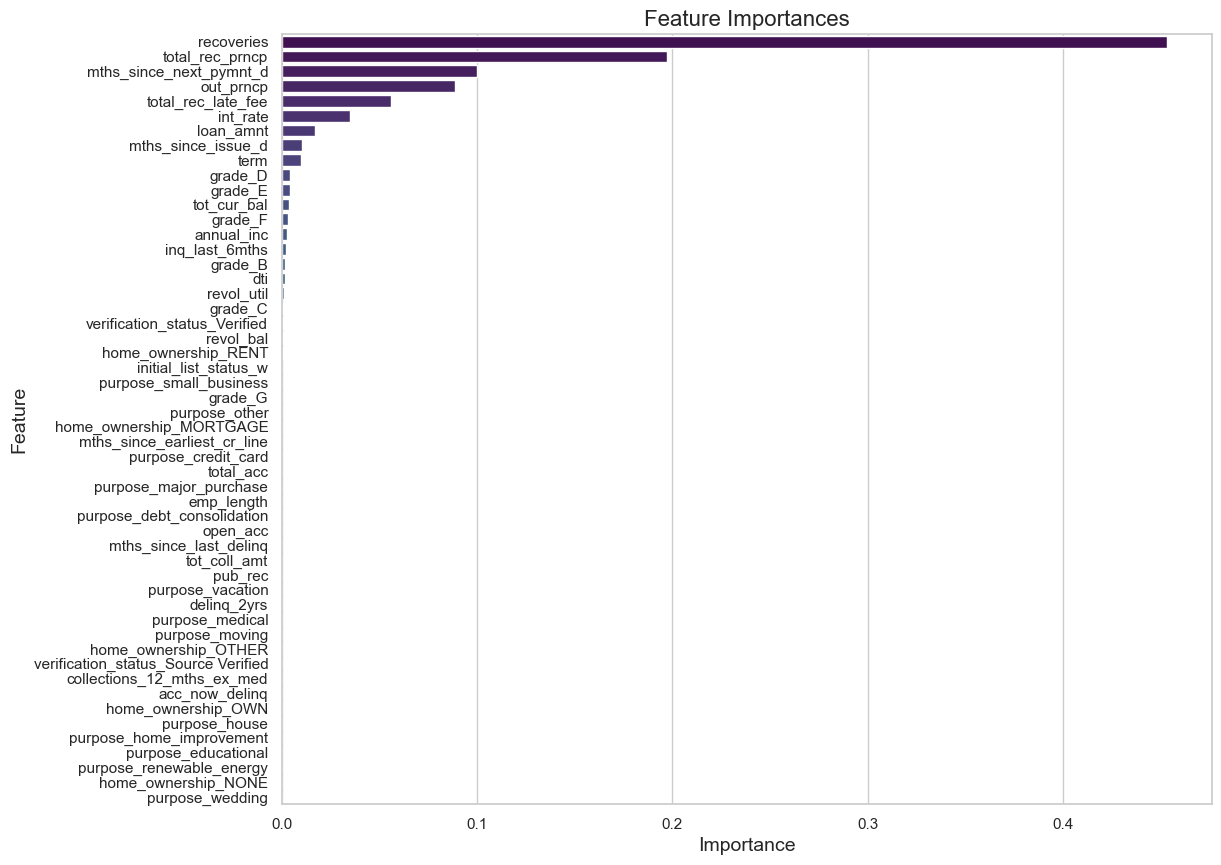

In [96]:
sns.set(style="whitegrid")
plt.figure(figsize=(12, 10))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette="viridis")
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.title('Feature Importances', fontsize=16)
plt.show()

Berdasarkan hasil analisis feature importance, kita dapat melihat bahwa beberapa fitur memiliki kontribusi yang signifikan dalam menentukan prediksi model.
* Fitur paling penting adalah `recoveries`, yang menunjukkan jumlah dana yang dipulihkan dari peminjam yang gagal membayar. 
* Fitur berikutnya yang signifikan adalah `total_rec_prncp`, yang merupakan total prinsipal yang telah diterima oleh pemberi pinjaman, dan `mths_since_next_pymnt_d`, yang menunjukkan jumlah bulan hingga pembayaran berikutnya.

## Recommendation

Beberapa hal lain yang dapat dilakukan untuk project ini:

- Melakukan hyperparameter tuning.

- Melakukan pemeriksaan atau memastikan bahwa model yang telah dibuat tidak overfitting. Hal ini dapat dilakukan dengan mencoba membandingkan hasil performa model ketika diprediksi terhadap data training dan ketika diprediksi terhadap data testing.